# Data Augmentation
In this file, we use the previously obtained data (such as raw image, optical flow image and gaze data) from the videos and augment them using mirroring technique. We use openCV for mirroring the raw and optical flow image. As far as gaze data is concerned we subtract gaze X value from 1 as the images are flipped horizontally 

In [1]:
#import the required models
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam
from keras.layers.merge import concatenate
import keras
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
from keras.layers.core import Reshape
import keras.backend as K
import datetime
import time
import telegram
from keras import metrics
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn import metrics
%pylab inline

Using TensorFlow backend.


# Load the HDF5 file

In [4]:
HDF5_PATH = '/home/gururajaramesh/completedata.hdf5'

In [5]:
hdf = h5py.File(HDF5_PATH, "r")

In [6]:
train_x1 = hdf["train/rawImages"]
train_x2 = hdf["train/flowImages"]
train_x3 = hdf["train/gazeData"]
train_y = hdf["train/labels"]


test_x1 = hdf["test/rawImages"]
test_x2 = hdf["test/flowImages"]
test_x3 = hdf["test/gazeData"]
test_y = hdf["test/labels"]

val_x1 = hdf["validation/rawImages"]
val_x2 = hdf["validation/flowImages"]
val_x3 = hdf["validation/gazeData"]
val_y = hdf["validation/labels"]

print(train_x1.shape, train_x2.shape, train_x3.shape, train_y.shape)
print(test_x1.shape, test_x2.shape, test_x3.shape, test_y.shape)
print(val_x1.shape, val_x2.shape, val_x3.shape, val_y.shape)

(17884, 224, 224, 3) (17884, 224, 224, 3) (17884, 60) (17884, 9)
(4665, 224, 224, 3) (4665, 224, 224, 3) (4665, 60) (4665, 9)
(1381, 224, 224, 3) (1381, 224, 224, 3) (1381, 60) (1381, 9)


In [ ]:
#copy the training labels from HDF5 file to y_true
y_true = np.zeros((17884,9), dtype=int)
for i in range(train_y.shape[0]):
    y_true[i] = train_y[i]
print(y_true.shape)
y_true[1:10]

In [12]:
#count the total number of patterns found in the training samples
firsttime = True
patternlist = []
countlist = []
for i in range(y_true.shape[0]):
    if(firsttime):
        curr_pattern = y_true[0,:]
        print('Found new pattern : %s' % curr_pattern)
        patternlist.append(curr_pattern)
        count = 0
        for j in range(y_true.shape[0]):
            #check if the pattern is same as the curr.pattern and increase count if not continue
            if(np.array_equal(curr_pattern, y_true[j,:])):
                count =  count + 1
            else:
                continue
        countlist.append(count)
        firsttime = False
        print('%s pattern found %s times' % (curr_pattern, count))
    else:
        curr_pattern = y_true[i,:]
        new_pattern = False
        already_present= False
        #check if curr_pattern is in patternlist
        for k in range(len(patternlist)):
            if(np.array_equal(curr_pattern, patternlist[k])):
                already_present = True
                break
            else:
                continue
        if(already_present):
            new_pattern = False
        else:
            new_pattern = True
        #if it is a new pattern  then count its occurance    
        if(new_pattern):
            print('Found new pattern : %s' % curr_pattern)
            patternlist.append(curr_pattern)
            count = 0
            for j in range(y_true.shape[0]):
                if(np.array_equal(curr_pattern, y_true[j,:])):
                    count = count + 1
                else:
                    continue
            countlist.append(count)
            print('%s pattern found %s times' % (curr_pattern, count))           

Found new pattern : [0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 0 0] pattern found 668 times
Found new pattern : [0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0] pattern found 316 times
Found new pattern : [0 1 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 1 0] pattern found 463 times
Found new pattern : [0 0 0 1 0 0 0 0 1]
[0 0 0 1 0 0 0 0 1] pattern found 268 times
Found new pattern : [1 0 0 1 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0] pattern found 482 times
Found new pattern : [1 0 0 1 0 0 0 0 1]
[1 0 0 1 0 0 0 0 1] pattern found 5 times
Found new pattern : [1 1 0 1 0 0 0 0 0]
[1 1 0 1 0 0 0 0 0] pattern found 267 times
Found new pattern : [1 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 1] pattern found 29 times
Found new pattern : [0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1] pattern found 1265 times
Found new pattern : [0 1 0 0 0 0 0 0 1]
[0 1 0 0 0 0 0 0 1] pattern found 128 times
Found new pattern : [0 1 0 1 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0] pattern found 184 times
Found new pattern : [0 0 0 0 1 0 0 0 1]
[0 0 0 0 1 0 0 0 1] pattern found 20 t

In [13]:
#total number of patterns found
len(countlist)

67

In [14]:
#combine the patternlist with corresponding count and sort the final patternlist according to count of patterns
npcl = np.asarray(countlist)
npll = np.asarray(patternlist)
nplist = np.zeros((67,10), dtype=np.int)
for i in range(npll.shape[0]):
    x = npll[i]
    y = npcl[i]
    nplist[i,0:9] = x
    nplist[i,9] = y
lst = np.copy(nplist)
sortedList = sorted(lst, key=lambda x: x[9], reverse=True)

In [25]:
print(sortedList)

[array([   0,    0,    1,    0,    1,    1,    0,    0,    0, 4667]),
 array([   0,    0,    0,    0,    0,    0,    1,    0,    0, 2676]),
 array([   0,    0,    0,    0,    1,    1,    0,    0,    0, 1736]),
 array([   0,    0,    1,    0,    1,    0,    0,    0,    0, 1495]),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    1, 1265]),
 array([  0,   1,   0,   0,   0,   0,   0,   0,   0, 867]),
 array([  0,   0,   0,   0,   0,   1,   0,   0,   0, 668]),
 array([  1,   0,   0,   1,   0,   0,   0,   0,   0, 482]),
 array([  0,   1,   0,   0,   0,   0,   0,   1,   0, 463]),
 array([  0,   0,   1,   0,   1,   0,   1,   0,   0, 407]),
 array([  0,   0,   0,   0,   0,   0,   0,   1,   0, 324]),
 array([  0,   0,   0,   1,   0,   0,   0,   0,   0, 316]),
 array([  0,   0,   0,   0,   0,   0,   1,   1,   0, 276]),
 array([  0,   0,   0,   1,   0,   0,   0,   0,   1, 268]),
 array([  1,   1,   0,   1,   0,   0,   0,   0,   0, 267]),
 array([  0,   1,   1,   0,   1,   1,   0,   0,   

In [30]:
#find the distribution of different activities
label = np.copy(y_true)
classesCount_percent = (np.sum(label, axis=0) / len(label))*100
classesCount = np.sum(label, axis=0)
print(classesCount_percent)
print(classesCount)

[ 5.38470141 15.024603   39.32565422  9.11988369 51.08476851 42.88190561
 20.14090807  7.64370387 12.13375084]
[ 963 2687 7033 1631 9136 7669 3602 1367 2170]


In [27]:
count = []
for i in range(9):
    x = classesCount_percent[i]
    count.append(x)
count

[5.384701409080742,
 15.024602997092373,
 39.32565421605905,
 9.119883694922835,
 51.08476850816373,
 42.88190561395661,
 20.14090807425632,
 7.6437038693804515,
 12.133750838738537]

In [28]:
oplabels = ['outdoor','social interaction','focused work','travel','reading','computer work','watching media','eating','special']

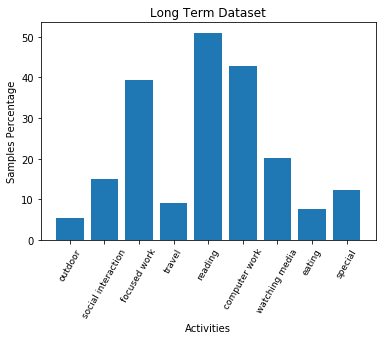

In [29]:
# plot the distribution of different activities before data augmentation
index = np.arange(len(oplabels))
plt.bar(index, count)
plt.xlabel('Activities', fontsize=10)
plt.ylabel('Samples Percentage', fontsize=10)
plt.xticks(index, oplabels, fontsize=9, rotation=60)
plt.title('Long Term Dataset')
plt.show()

In [121]:
#choose the pattern for augmentation
x = (0,0,0,0,0,0,0,0,1)
curr_pattern = np.asarray(x)

In [122]:
#find the indexes of the chosen pattern in the HDF5 file
indexlist = []
for i in range(train_y.shape[0]):
    if(np.array_equal(curr_pattern, train_y[i])):
        indexlist.append(i)
        print('%s pattern found in %s index' % (train_y[i], i))
print('%s pattern was found %s times' % (curr_pattern, len(indexlist)))
print('Finished Processing pattern %s'% curr_pattern)
npindexlist = np.asarray(indexlist)
np.save('/home/gururajaramesh/activity2_indexlist_train.npy',npindexlist)

[0 0 0 0 0 0 0 0 1] pattern found in 401 index
[0 0 0 0 0 0 0 0 1] pattern found in 402 index
[0 0 0 0 0 0 0 0 1] pattern found in 449 index
[0 0 0 0 0 0 0 0 1] pattern found in 450 index
[0 0 0 0 0 0 0 0 1] pattern found in 451 index
[0 0 0 0 0 0 0 0 1] pattern found in 452 index
[0 0 0 0 0 0 0 0 1] pattern found in 453 index
[0 0 0 0 0 0 0 0 1] pattern found in 454 index
[0 0 0 0 0 0 0 0 1] pattern found in 455 index
[0 0 0 0 0 0 0 0 1] pattern found in 459 index
[0 0 0 0 0 0 0 0 1] pattern found in 460 index
[0 0 0 0 0 0 0 0 1] pattern found in 461 index
[0 0 0 0 0 0 0 0 1] pattern found in 474 index
[0 0 0 0 0 0 0 0 1] pattern found in 942 index
[0 0 0 0 0 0 0 0 1] pattern found in 1484 index
[0 0 0 0 0 0 0 0 1] pattern found in 1485 index
[0 0 0 0 0 0 0 0 1] pattern found in 1486 index
[0 0 0 0 0 0 0 0 1] pattern found in 1487 index
[0 0 0 0 0 0 0 0 1] pattern found in 1524 index
[0 0 0 0 0 0 0 0 1] pattern found in 1525 index
[0 0 0 0 0 0 0 0 1] pattern found in 1691 index
[0 0 0

[0 0 0 0 0 0 0 0 1] pattern found in 4483 index
[0 0 0 0 0 0 0 0 1] pattern found in 4484 index
[0 0 0 0 0 0 0 0 1] pattern found in 4745 index
[0 0 0 0 0 0 0 0 1] pattern found in 4746 index
[0 0 0 0 0 0 0 0 1] pattern found in 4747 index
[0 0 0 0 0 0 0 0 1] pattern found in 4748 index
[0 0 0 0 0 0 0 0 1] pattern found in 4749 index
[0 0 0 0 0 0 0 0 1] pattern found in 4750 index
[0 0 0 0 0 0 0 0 1] pattern found in 4751 index
[0 0 0 0 0 0 0 0 1] pattern found in 4752 index
[0 0 0 0 0 0 0 0 1] pattern found in 4753 index
[0 0 0 0 0 0 0 0 1] pattern found in 4754 index
[0 0 0 0 0 0 0 0 1] pattern found in 4755 index
[0 0 0 0 0 0 0 0 1] pattern found in 4756 index
[0 0 0 0 0 0 0 0 1] pattern found in 5219 index
[0 0 0 0 0 0 0 0 1] pattern found in 5220 index
[0 0 0 0 0 0 0 0 1] pattern found in 5221 index
[0 0 0 0 0 0 0 0 1] pattern found in 5222 index
[0 0 0 0 0 0 0 0 1] pattern found in 5288 index
[0 0 0 0 0 0 0 0 1] pattern found in 5289 index
[0 0 0 0 0 0 0 0 1] pattern found in 529

[0 0 0 0 0 0 0 0 1] pattern found in 7121 index
[0 0 0 0 0 0 0 0 1] pattern found in 7125 index
[0 0 0 0 0 0 0 0 1] pattern found in 7126 index
[0 0 0 0 0 0 0 0 1] pattern found in 7127 index
[0 0 0 0 0 0 0 0 1] pattern found in 7128 index
[0 0 0 0 0 0 0 0 1] pattern found in 7129 index
[0 0 0 0 0 0 0 0 1] pattern found in 7130 index
[0 0 0 0 0 0 0 0 1] pattern found in 7131 index
[0 0 0 0 0 0 0 0 1] pattern found in 7132 index
[0 0 0 0 0 0 0 0 1] pattern found in 7133 index
[0 0 0 0 0 0 0 0 1] pattern found in 7134 index
[0 0 0 0 0 0 0 0 1] pattern found in 7135 index
[0 0 0 0 0 0 0 0 1] pattern found in 7136 index
[0 0 0 0 0 0 0 0 1] pattern found in 7137 index
[0 0 0 0 0 0 0 0 1] pattern found in 7138 index
[0 0 0 0 0 0 0 0 1] pattern found in 7142 index
[0 0 0 0 0 0 0 0 1] pattern found in 7143 index
[0 0 0 0 0 0 0 0 1] pattern found in 7144 index
[0 0 0 0 0 0 0 0 1] pattern found in 7145 index
[0 0 0 0 0 0 0 0 1] pattern found in 7146 index
[0 0 0 0 0 0 0 0 1] pattern found in 714

[0 0 0 0 0 0 0 0 1] pattern found in 9450 index
[0 0 0 0 0 0 0 0 1] pattern found in 9456 index
[0 0 0 0 0 0 0 0 1] pattern found in 9457 index
[0 0 0 0 0 0 0 0 1] pattern found in 9465 index
[0 0 0 0 0 0 0 0 1] pattern found in 9466 index
[0 0 0 0 0 0 0 0 1] pattern found in 9467 index
[0 0 0 0 0 0 0 0 1] pattern found in 9468 index
[0 0 0 0 0 0 0 0 1] pattern found in 9469 index
[0 0 0 0 0 0 0 0 1] pattern found in 9470 index
[0 0 0 0 0 0 0 0 1] pattern found in 9471 index
[0 0 0 0 0 0 0 0 1] pattern found in 9472 index
[0 0 0 0 0 0 0 0 1] pattern found in 9473 index
[0 0 0 0 0 0 0 0 1] pattern found in 9474 index
[0 0 0 0 0 0 0 0 1] pattern found in 9486 index
[0 0 0 0 0 0 0 0 1] pattern found in 9487 index
[0 0 0 0 0 0 0 0 1] pattern found in 9488 index
[0 0 0 0 0 0 0 0 1] pattern found in 9489 index
[0 0 0 0 0 0 0 0 1] pattern found in 9490 index
[0 0 0 0 0 0 0 0 1] pattern found in 9491 index
[0 0 0 0 0 0 0 0 1] pattern found in 9492 index
[0 0 0 0 0 0 0 0 1] pattern found in 949

[0 0 0 0 0 0 0 0 1] pattern found in 12760 index
[0 0 0 0 0 0 0 0 1] pattern found in 12764 index
[0 0 0 0 0 0 0 0 1] pattern found in 12765 index
[0 0 0 0 0 0 0 0 1] pattern found in 12766 index
[0 0 0 0 0 0 0 0 1] pattern found in 12815 index
[0 0 0 0 0 0 0 0 1] pattern found in 12816 index
[0 0 0 0 0 0 0 0 1] pattern found in 12817 index
[0 0 0 0 0 0 0 0 1] pattern found in 12818 index
[0 0 0 0 0 0 0 0 1] pattern found in 12819 index
[0 0 0 0 0 0 0 0 1] pattern found in 12820 index
[0 0 0 0 0 0 0 0 1] pattern found in 12821 index
[0 0 0 0 0 0 0 0 1] pattern found in 12882 index
[0 0 0 0 0 0 0 0 1] pattern found in 13048 index
[0 0 0 0 0 0 0 0 1] pattern found in 13049 index
[0 0 0 0 0 0 0 0 1] pattern found in 13050 index
[0 0 0 0 0 0 0 0 1] pattern found in 13165 index
[0 0 0 0 0 0 0 0 1] pattern found in 13166 index
[0 0 0 0 0 0 0 0 1] pattern found in 13167 index
[0 0 0 0 0 0 0 0 1] pattern found in 13168 index
[0 0 0 0 0 0 0 0 1] pattern found in 13169 index
[0 0 0 0 0 0 0 0 1] 

[0 0 0 0 0 0 0 0 1] pattern found in 15666 index
[0 0 0 0 0 0 0 0 1] pattern found in 15667 index
[0 0 0 0 0 0 0 0 1] pattern found in 15676 index
[0 0 0 0 0 0 0 0 1] pattern found in 15835 index
[0 0 0 0 0 0 0 0 1] pattern found in 15836 index
[0 0 0 0 0 0 0 0 1] pattern found in 15837 index
[0 0 0 0 0 0 0 0 1] pattern found in 15838 index
[0 0 0 0 0 0 0 0 1] pattern found in 15839 index
[0 0 0 0 0 0 0 0 1] pattern found in 15851 index
[0 0 0 0 0 0 0 0 1] pattern found in 15852 index
[0 0 0 0 0 0 0 0 1] pattern found in 15853 index
[0 0 0 0 0 0 0 0 1] pattern found in 15854 index
[0 0 0 0 0 0 0 0 1] pattern found in 15855 index
[0 0 0 0 0 0 0 0 1] pattern found in 15856 index
[0 0 0 0 0 0 0 0 1] pattern found in 15857 index
[0 0 0 0 0 0 0 0 1] pattern found in 15858 index
[0 0 0 0 0 0 0 0 1] pattern found in 16067 index
[0 0 0 0 0 0 0 0 1] pattern found in 16068 index
[0 0 0 0 0 0 0 0 1] pattern found in 16069 index
[0 0 0 0 0 0 0 0 1] pattern found in 16070 index
[0 0 0 0 0 0 0 0 1] 

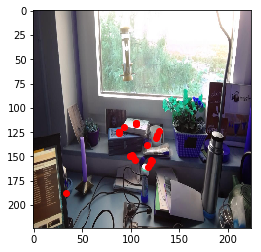

In [137]:
img = train_x1[7664]
plt.imshow(img)
gaze = train_x3[7664]
gaze = gaze.reshape(30,-1)
plt.scatter(gaze[:,0]*img.shape[1], gaze[:,1]*img.shape[0], c="r")
plt.show()

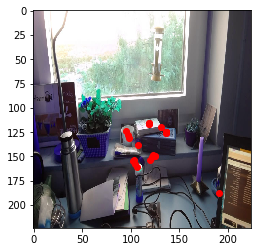

In [139]:
flippedimg = cv2.flip(img, 1)
plt.imshow(flippedimg)
for i in range(gaze.shape[0]):
    newGazeX = 1-gaze[i,0]
    gaze[i,0] = newGazeX
plt.scatter(gaze[:,0]*flippedimg.shape[1], gaze[:,1]*flippedimg.shape[0], c="r")
plt.show()

# Load another HDF5 file for storing augmented data

In [72]:
HDF5_PATH2 = '/home/gururajaramesh/completedata_withP10.hdf5'

In [73]:
if Path(HDF5_PATH2).is_file():
    print("Open storage for appending.")
    hdf2 = h5py.File(HDF5_PATH2, mode='a')
else:
    print("Creating new storage for writing.")
    hdf2 = h5py.File(HDF5_PATH2, mode='w') 

Open storage for appending.


In [74]:
#function to add newly augmented data to the HDF5 file
def add_to_hdf(hdf, rawImage, flowImage, gazeData, label_vals, set_name):
    groupName = set_name
    pGroup = None
    groupExists = "/" + groupName in hdf
    if not (groupExists):
        pGroup = hdf.create_group(groupName)
    else:
        pGroup = hdf["/" + groupName]
    
    if not (groupExists):
        pGroup.create_dataset("rawImages", data=rawImage, maxshape=(None, 224, 224, 3), chunks=True)
        pGroup.create_dataset("flowImages", data=flowImage, maxshape=(None, 224, 224, 3), chunks=True)  
        pGroup.create_dataset("gazeData", data=gazeData, maxshape=(None, 60), chunks=True) 
        pGroup.create_dataset("labels", data=label_vals, maxshape=(None, 9), chunks=True)
        print('All Groups created')
    else:
        pGroup["rawImages"].resize((pGroup["rawImages"].shape[0] + rawImage.shape[0]), axis = 0)
        pGroup["rawImages"][-rawImage.shape[0]:] = rawImage
        pGroup["flowImages"].resize((pGroup["flowImages"].shape[0] + flowImage.shape[0]), axis = 0)
        pGroup["flowImages"][-flowImage.shape[0]:] = flowImage
        pGroup["gazeData"].resize((pGroup["gazeData"].shape[0] + gazeData.shape[0]), axis = 0)
        pGroup["gazeData"][-gazeData.shape[0]:] = gazeData
        pGroup["labels"].resize((pGroup["labels"].shape[0] + label_vals.shape[0]), axis = 0)
        pGroup["labels"][-label_vals.shape[0]:] = label_vals

In [123]:
#obtain the data using the index data and augment them
counter = 0
for i in range(npindexlist.shape[0]):
    curr_index = npindexlist[i]
    img = train_x1[curr_index]
    flippedImg = cv2.flip(img, 1)
    reshaped_rawImage = flippedImg.reshape(-1,224,224,3)
    flow = train_x2[curr_index]
    flippedFlow = cv2.flip(flow, 1)
    reshaped_flowImage = flippedFlow.reshape(-1,224,224,3)
    gaze = train_x3[curr_index]
    gaze = gaze.reshape(30,-1)
    for i in range(gaze.shape[0]):
        newGazeX = 1-gaze[i,0]
        gaze[i,0] = newGazeX
    reshaped_gazeData = gaze.reshape(-1,60)
    label = train_y[curr_index]
    reshaped_label = label.reshape(-1,9)
    add_to_hdf(hdf2, reshaped_rawImage, reshaped_flowImage, reshaped_gazeData, reshaped_label, "train")
    counter = counter + 1
    print("%s index is complted" % curr_index)
    print("%s frames completed out of %s" % (counter, npindexlist.shape[0]))   

401 index is complted
1 frames completed out of 1265
402 index is complted
2 frames completed out of 1265
449 index is complted
3 frames completed out of 1265
450 index is complted
4 frames completed out of 1265
451 index is complted
5 frames completed out of 1265
452 index is complted
6 frames completed out of 1265
453 index is complted
7 frames completed out of 1265
454 index is complted
8 frames completed out of 1265
455 index is complted
9 frames completed out of 1265
459 index is complted
10 frames completed out of 1265
460 index is complted
11 frames completed out of 1265
461 index is complted
12 frames completed out of 1265
474 index is complted
13 frames completed out of 1265
942 index is complted
14 frames completed out of 1265
1484 index is complted
15 frames completed out of 1265
1485 index is complted
16 frames completed out of 1265
1486 index is complted
17 frames completed out of 1265
1487 index is complted
18 frames completed out of 1265
1524 index is complted
19 frames 

4369 index is complted
152 frames completed out of 1265
4370 index is complted
153 frames completed out of 1265
4371 index is complted
154 frames completed out of 1265
4372 index is complted
155 frames completed out of 1265
4373 index is complted
156 frames completed out of 1265
4374 index is complted
157 frames completed out of 1265
4375 index is complted
158 frames completed out of 1265
4376 index is complted
159 frames completed out of 1265
4377 index is complted
160 frames completed out of 1265
4378 index is complted
161 frames completed out of 1265
4379 index is complted
162 frames completed out of 1265
4380 index is complted
163 frames completed out of 1265
4381 index is complted
164 frames completed out of 1265
4382 index is complted
165 frames completed out of 1265
4383 index is complted
166 frames completed out of 1265
4384 index is complted
167 frames completed out of 1265
4385 index is complted
168 frames completed out of 1265
4386 index is complted
169 frames completed out 

6943 index is complted
300 frames completed out of 1265
6944 index is complted
301 frames completed out of 1265
6945 index is complted
302 frames completed out of 1265
6946 index is complted
303 frames completed out of 1265
6951 index is complted
304 frames completed out of 1265
6952 index is complted
305 frames completed out of 1265
6953 index is complted
306 frames completed out of 1265
6954 index is complted
307 frames completed out of 1265
6955 index is complted
308 frames completed out of 1265
6956 index is complted
309 frames completed out of 1265
6957 index is complted
310 frames completed out of 1265
6958 index is complted
311 frames completed out of 1265
6959 index is complted
312 frames completed out of 1265
6960 index is complted
313 frames completed out of 1265
6968 index is complted
314 frames completed out of 1265
6969 index is complted
315 frames completed out of 1265
6970 index is complted
316 frames completed out of 1265
6971 index is complted
317 frames completed out 

7143 index is complted
448 frames completed out of 1265
7144 index is complted
449 frames completed out of 1265
7145 index is complted
450 frames completed out of 1265
7146 index is complted
451 frames completed out of 1265
7147 index is complted
452 frames completed out of 1265
7148 index is complted
453 frames completed out of 1265
7149 index is complted
454 frames completed out of 1265
7150 index is complted
455 frames completed out of 1265
7151 index is complted
456 frames completed out of 1265
7152 index is complted
457 frames completed out of 1265
7153 index is complted
458 frames completed out of 1265
7166 index is complted
459 frames completed out of 1265
7167 index is complted
460 frames completed out of 1265
7273 index is complted
461 frames completed out of 1265
7277 index is complted
462 frames completed out of 1265
7287 index is complted
463 frames completed out of 1265
7288 index is complted
464 frames completed out of 1265
7527 index is complted
465 frames completed out 

9206 index is complted
618 frames completed out of 1265
9207 index is complted
619 frames completed out of 1265
9212 index is complted
620 frames completed out of 1265
9213 index is complted
621 frames completed out of 1265
9214 index is complted
622 frames completed out of 1265
9218 index is complted
623 frames completed out of 1265
9219 index is complted
624 frames completed out of 1265
9220 index is complted
625 frames completed out of 1265
9221 index is complted
626 frames completed out of 1265
9228 index is complted
627 frames completed out of 1265
9229 index is complted
628 frames completed out of 1265
9242 index is complted
629 frames completed out of 1265
9243 index is complted
630 frames completed out of 1265
9259 index is complted
631 frames completed out of 1265
9260 index is complted
632 frames completed out of 1265
9312 index is complted
633 frames completed out of 1265
9313 index is complted
634 frames completed out of 1265
9450 index is complted
635 frames completed out 

11860 index is complted
803 frames completed out of 1265
11861 index is complted
804 frames completed out of 1265
11862 index is complted
805 frames completed out of 1265
11863 index is complted
806 frames completed out of 1265
11878 index is complted
807 frames completed out of 1265
11920 index is complted
808 frames completed out of 1265
11921 index is complted
809 frames completed out of 1265
11922 index is complted
810 frames completed out of 1265
11923 index is complted
811 frames completed out of 1265
11924 index is complted
812 frames completed out of 1265
11925 index is complted
813 frames completed out of 1265
11926 index is complted
814 frames completed out of 1265
11927 index is complted
815 frames completed out of 1265
11928 index is complted
816 frames completed out of 1265
11929 index is complted
817 frames completed out of 1265
11930 index is complted
818 frames completed out of 1265
11931 index is complted
819 frames completed out of 1265
11932 index is complted
820 fra

12486 index is complted
956 frames completed out of 1265
12487 index is complted
957 frames completed out of 1265
12490 index is complted
958 frames completed out of 1265
12491 index is complted
959 frames completed out of 1265
12492 index is complted
960 frames completed out of 1265
12493 index is complted
961 frames completed out of 1265
12494 index is complted
962 frames completed out of 1265
12495 index is complted
963 frames completed out of 1265
12620 index is complted
964 frames completed out of 1265
12743 index is complted
965 frames completed out of 1265
12744 index is complted
966 frames completed out of 1265
12745 index is complted
967 frames completed out of 1265
12746 index is complted
968 frames completed out of 1265
12749 index is complted
969 frames completed out of 1265
12757 index is complted
970 frames completed out of 1265
12758 index is complted
971 frames completed out of 1265
12759 index is complted
972 frames completed out of 1265
12760 index is complted
973 fra

14322 index is complted
1140 frames completed out of 1265
14323 index is complted
1141 frames completed out of 1265
14324 index is complted
1142 frames completed out of 1265
14325 index is complted
1143 frames completed out of 1265
14326 index is complted
1144 frames completed out of 1265
14327 index is complted
1145 frames completed out of 1265
14328 index is complted
1146 frames completed out of 1265
14329 index is complted
1147 frames completed out of 1265
14330 index is complted
1148 frames completed out of 1265
14331 index is complted
1149 frames completed out of 1265
14332 index is complted
1150 frames completed out of 1265
14333 index is complted
1151 frames completed out of 1265
14334 index is complted
1152 frames completed out of 1265
14335 index is complted
1153 frames completed out of 1265
14336 index is complted
1154 frames completed out of 1265
14337 index is complted
1155 frames completed out of 1265
14338 index is complted
1156 frames completed out of 1265
14339 index is

In [124]:
#difference in sample count before and after data augmentation
train2_x1 = hdf2["train/rawImages"]
train2_x2 = hdf2["train/flowImages"]
train2_x3 = hdf2["train/gazeData"]
train2_y = hdf2["train/labels"]

#sample count before data augmentation
print(train_x1.shape, train_x2.shape, train_x3.shape, train_y.shape)

#sample count after data augmentation
print(train2_x1.shape, train2_x2.shape, train2_x3.shape, train2_y.shape)

(17884, 224, 224, 3) (17884, 224, 224, 3) (17884, 60) (17884, 9)
(25205, 224, 224, 3) (25205, 224, 224, 3) (25205, 60) (25205, 9)


In [126]:
#obtain the newly augmented data from the HDF5 file
y_true2 = np.zeros((25205,9), dtype=int)
for i in range(train2_y.shape[0]):
    y_true2[i] = train2_y[i]
print(y_true2.shape)

(25205, 9)


In [127]:
#find the distribution of different activities
label2 = np.copy(y_true2)
classesCount_percent2 = (np.sum(label2, axis=0) / len(label2))*100
classesCount2 = np.sum(label2, axis=0)
print(classesCount_percent2)
print(classesCount2)

[ 7.11366792 18.55584209 27.90319381 12.4895854  36.24677643 30.42650268
 24.9077564   8.86728824 15.52073001]
[1793 4677 7033 3148 9136 7669 6278 2235 3912]


In [128]:
count2 = []
for i in range(9):
    x = classesCount_percent2[i]
    count2.append(x)
count2

[7.113667923031144,
 18.555842094822456,
 27.903193810751837,
 12.489585399722278,
 36.246776433247376,
 30.426502678040073,
 24.90775639754017,
 8.86728823646102,
 15.520730013886133]

In [129]:
oplabels = ['outdoor','social interaction','focused work','travel','reading','computer work','watching media','eating','special']

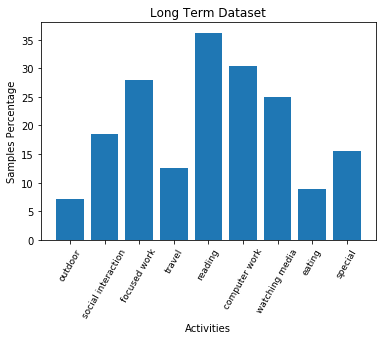

In [130]:
# plot the distribution of different activities after data augmentation
index = np.arange(len(oplabels))
plt.bar(index, count2)
plt.xlabel('Activities', fontsize=10)
plt.ylabel('Samples Percentage', fontsize=10)
plt.xticks(index, oplabels, fontsize=9, rotation=60)
plt.title('Long Term Dataset')
plt.show()

In [141]:
hdf.close()
hdf2.close()